# Compare observer runaways to theory runaways

In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("default")


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# The plan

Currently observations of runaways are not measuring quite the same things as theory predicts and this may cause confusion when trying to constrain models making predictions of runaways.

Observations of runaways define them as stars which have a velocity
$$v = || v_{2, \rm today} - v_{\rm Gal}(x_{\rm today}) || > 30 \, {\rm km / s}$$
whereas theoretical predictions instead require
$$v = || v_{2, \rm SN1} - v_{\rm CM, SN1} || > 30 \, {\rm km / s}$$


The key difference here being that the star will have moved far from the original supernova location and so you could be comparing two very different populations. We're going to check how different these values actually are on a population level and so the two things we want to answer are:

1. How much does the velocity change (i.e. $v_{\rm 2, TAMS}$ vs. $v_{\rm 2, SN1}$) for runaway stars
2. How different are the observational and theory velocities

# Prep data

## First the simulation

In [3]:
%%time
p = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/supernovae/vir_1.0-ce_1.0")

CPU times: user 14 s, sys: 7.36 s, total: 21.4 s
Wall time: 42.8 s


In [4]:
%%time
p.orbits

CPU times: user 3min 42s, sys: 44.5 s, total: 4min 26s
Wall time: 5min 26s


array([<Orbit cartesian, dim=3, shape=(201,)>,
       <Orbit cartesian, dim=3, shape=(201,)>,
       <Orbit cartesian, dim=3, shape=(201,)>, ...,
       <Orbit cartesian, dim=3, shape=(263,)>,
       <Orbit cartesian, dim=3, shape=(263,)>,
       <Orbit cartesian, dim=3, shape=(263,)>], dtype=object)

## Then the star particles

In [6]:
star_particles = pd.read_hdf("FIRE_star_particles.h5")
try:
    particle_orbits = np.load("particle_orbits.npy", allow_pickle=True)
except:
    particle_orbits = [None for _ in range(len(star_particles))]
    for i in range(len(star_particles)):
        if i % 1000 == 0:
            print(i)
        w0 = gd.PhaseSpacePosition(pos=star_particles.iloc[i][["x", "y", "z"]].values * u.kpc,
                                vel=star_particles.iloc[i][["v_x", "v_y", "v_z"]].values * u.km / u.s)
        min_dt = (p.max_ev_time - star_particles.iloc[i]["t_form"] * u.Gyr).to(u.Myr).value
        if min_dt <= 0.01:
            continue
        particle_orbits[i] = p.galactic_potential.integrate_orbit(w0,
                                                                  t1=star_particles.iloc[i]["t_form"] * u.Gyr,
                                                                  t2=p.max_ev_time,
                                                                  dt=min(min_dt - 0.01, 1) * u.Myr)
    np.save("particle_orbits.npy", particle_orbits)

# Select out the right binaries

We only want things that:
1. Received a supernova kick at some point
2. After that time, had a secondary on the main sequence with Teff > 30,000 K

In [7]:
was_kicked = (p.bpp["evol_type"] == 15) | (p.bpp["evol_type"] == 16)
kicked_bin_nums = p.bpp["bin_num"][was_kicked].unique()
kicked_mask = np.isin(p.bin_nums, kicked_bin_nums)

In [8]:
p_kick = p[kicked_bin_nums]

In [9]:
p_runaways = p_kick[p_kick.bpp[(p_kick.bpp["kstar_2"] <= 1) & (p_kick.bpp["teff_2"] >= 30000)]["bin_num"].unique()]

# Velocity changes

In [11]:
p, p_kick, p_runaways

(<Population - 2161026 evolved systems - galactic_potential=CompositePotential, galaxy_model=Galaxy>,
 <Population - 1026418 evolved systems - galactic_potential=CompositePotential, galaxy_model=Galaxy>,
 <Population - 150068 evolved systems - galactic_potential=CompositePotential, galaxy_model=Galaxy>)

In [225]:
from matplotlib.colors import LogNorm

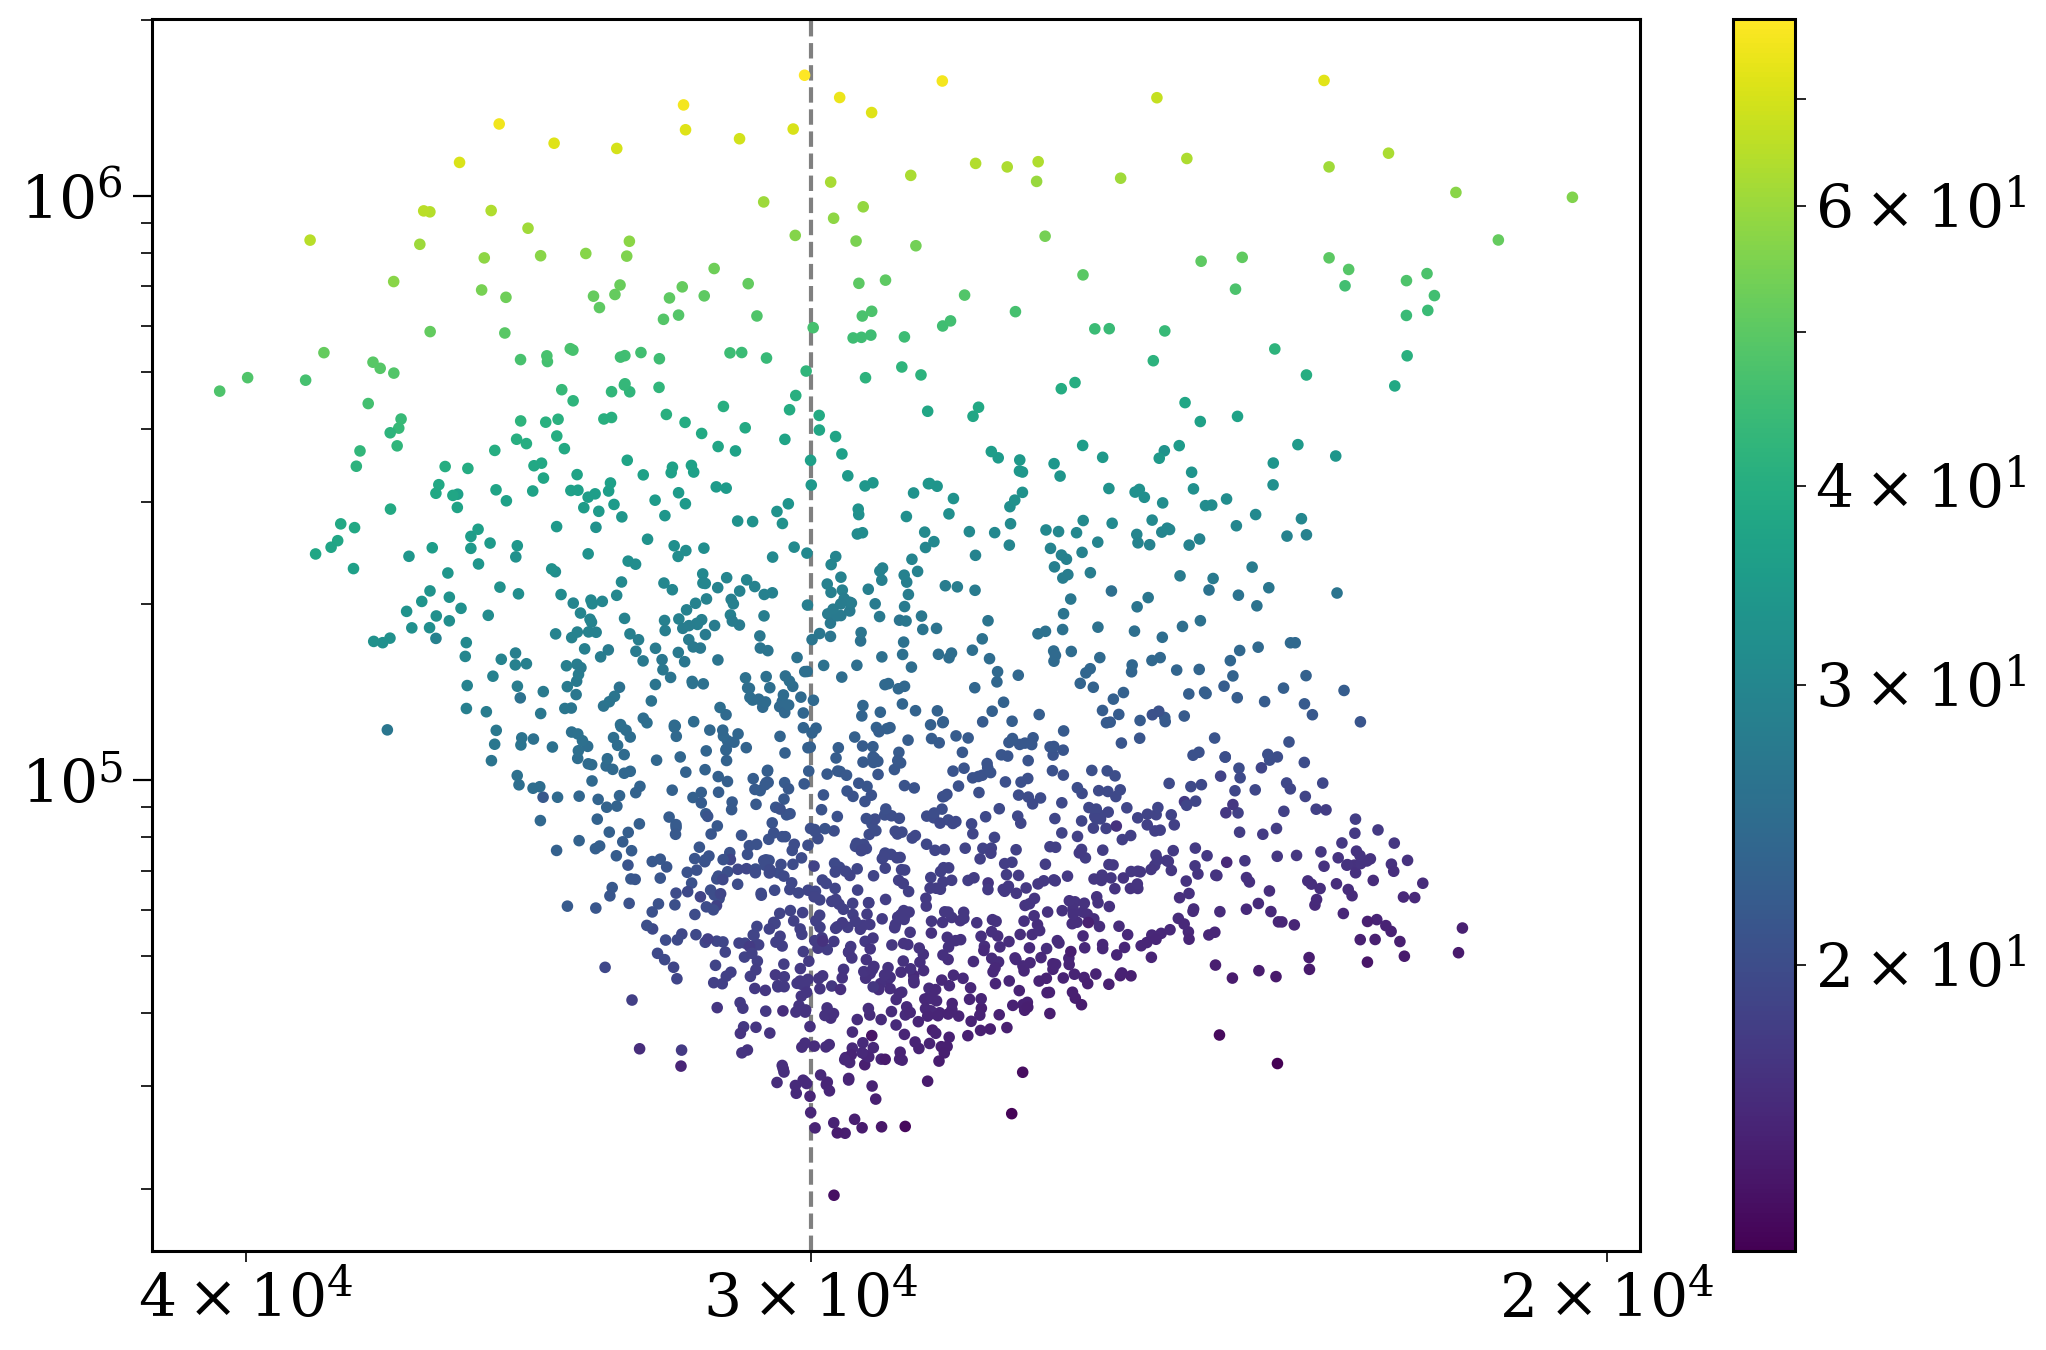

In [230]:
scatter = plt.scatter(*p_runaways.final_bpp[["teff_2", "lum_2"]].values.T, s=10, c=p_runaways.final_bpp["mass_2"], norm=LogNorm())
plt.colorbar(scatter)
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_xaxis()
plt.axvline(30000, color="grey", zorder=-1, linestyle="--")

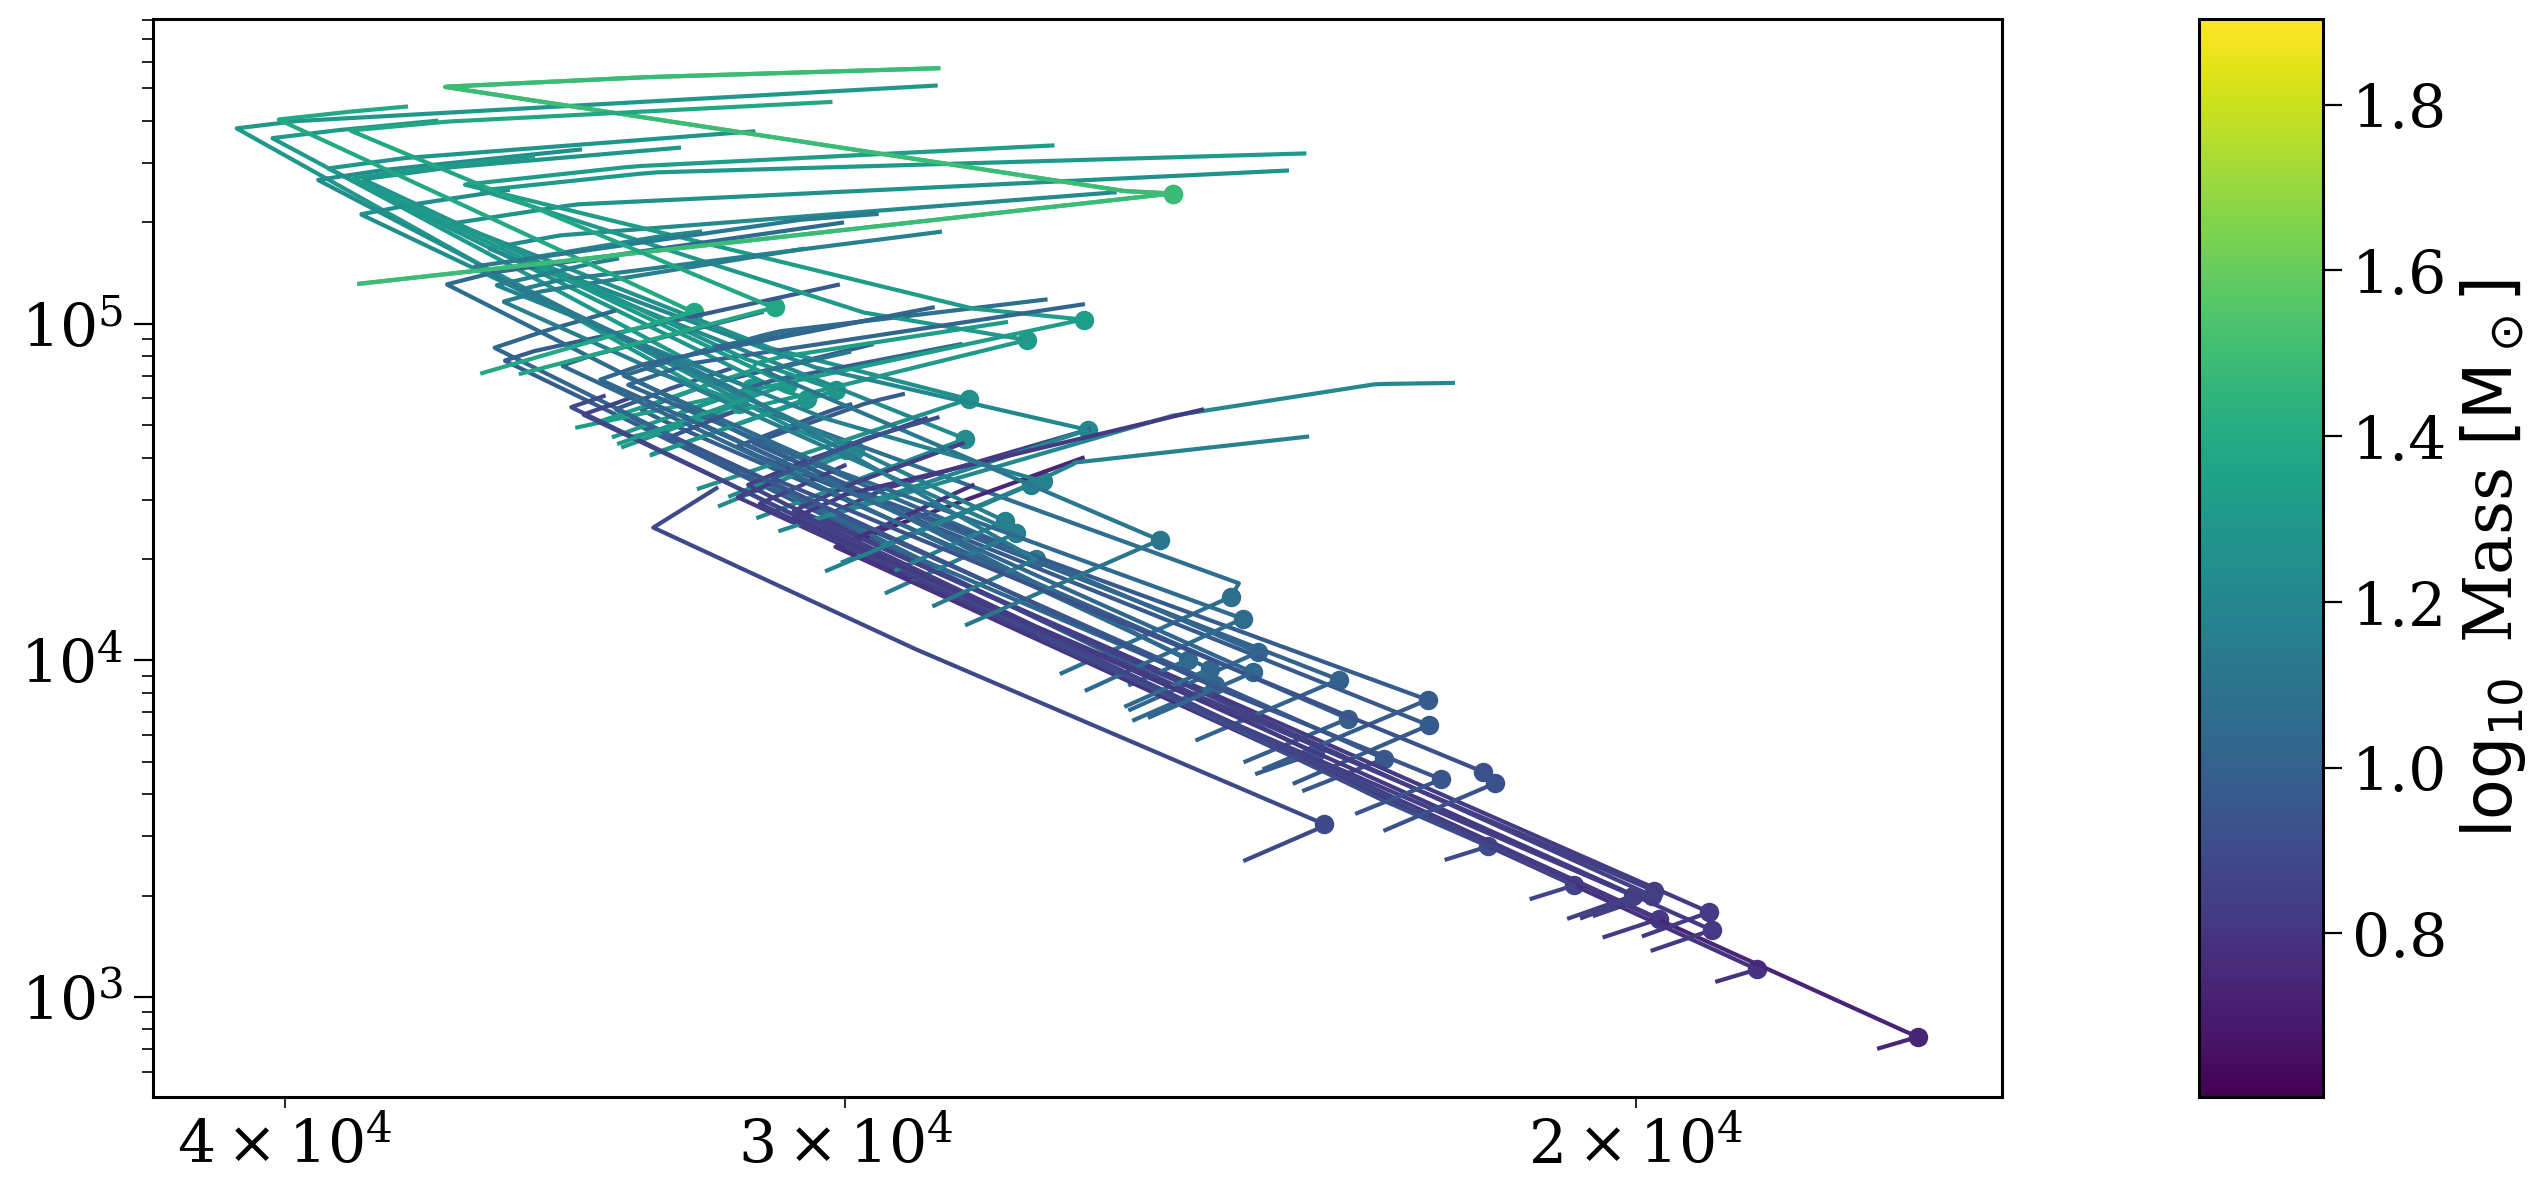

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={"width_ratios": [15, 1]})
ax, cbar_ax = axes

cmap = plt.cm.viridis

for bin_num in p_runaways.bin_nums[np.random.randint(len(p_runaways), size=50)]:
    # print(p_runaways.bpp.loc[bin_num][["teff_2", "lum_2"]])
    m = np.log10(p_runaways.initC.loc[bin_num]["mass_2"])
    m = (m - np.log10(4)) / (np.log10(80) - np.log10(4))
    ax.plot(*p_runaways.bpp.loc[bin_num][["teff_2", "lum_2"]].values.T, c=cmap(m))
    ax.scatter(*p_runaways.bpp.loc[bin_num][p_runaways.bpp.loc[bin_num]["evol_type"] == 3][["teff_2", "lum_2"]].values.T, color=cmap(m))
    
ax.set(xscale="log", yscale="log")
ax.invert_xaxis()

norm = mpl.colors.Normalize(vmin=np.log10(4), vmax=np.log10(80))
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, label=r"$\log_{10}$ Mass $[\rm M_\odot]$")
                                   
plt.show()

(array([ 38., 329., 436., 282., 231., 111.,  66.,  32.,  19.,  10.]),
 array([0.65487494, 0.78148219, 0.90808943, 1.03469668, 1.16130392,
        1.28791116, 1.41451841, 1.54112565, 1.6677329 , 1.79434014,
        1.92094738]),
 <BarContainer object of 10 artists>)

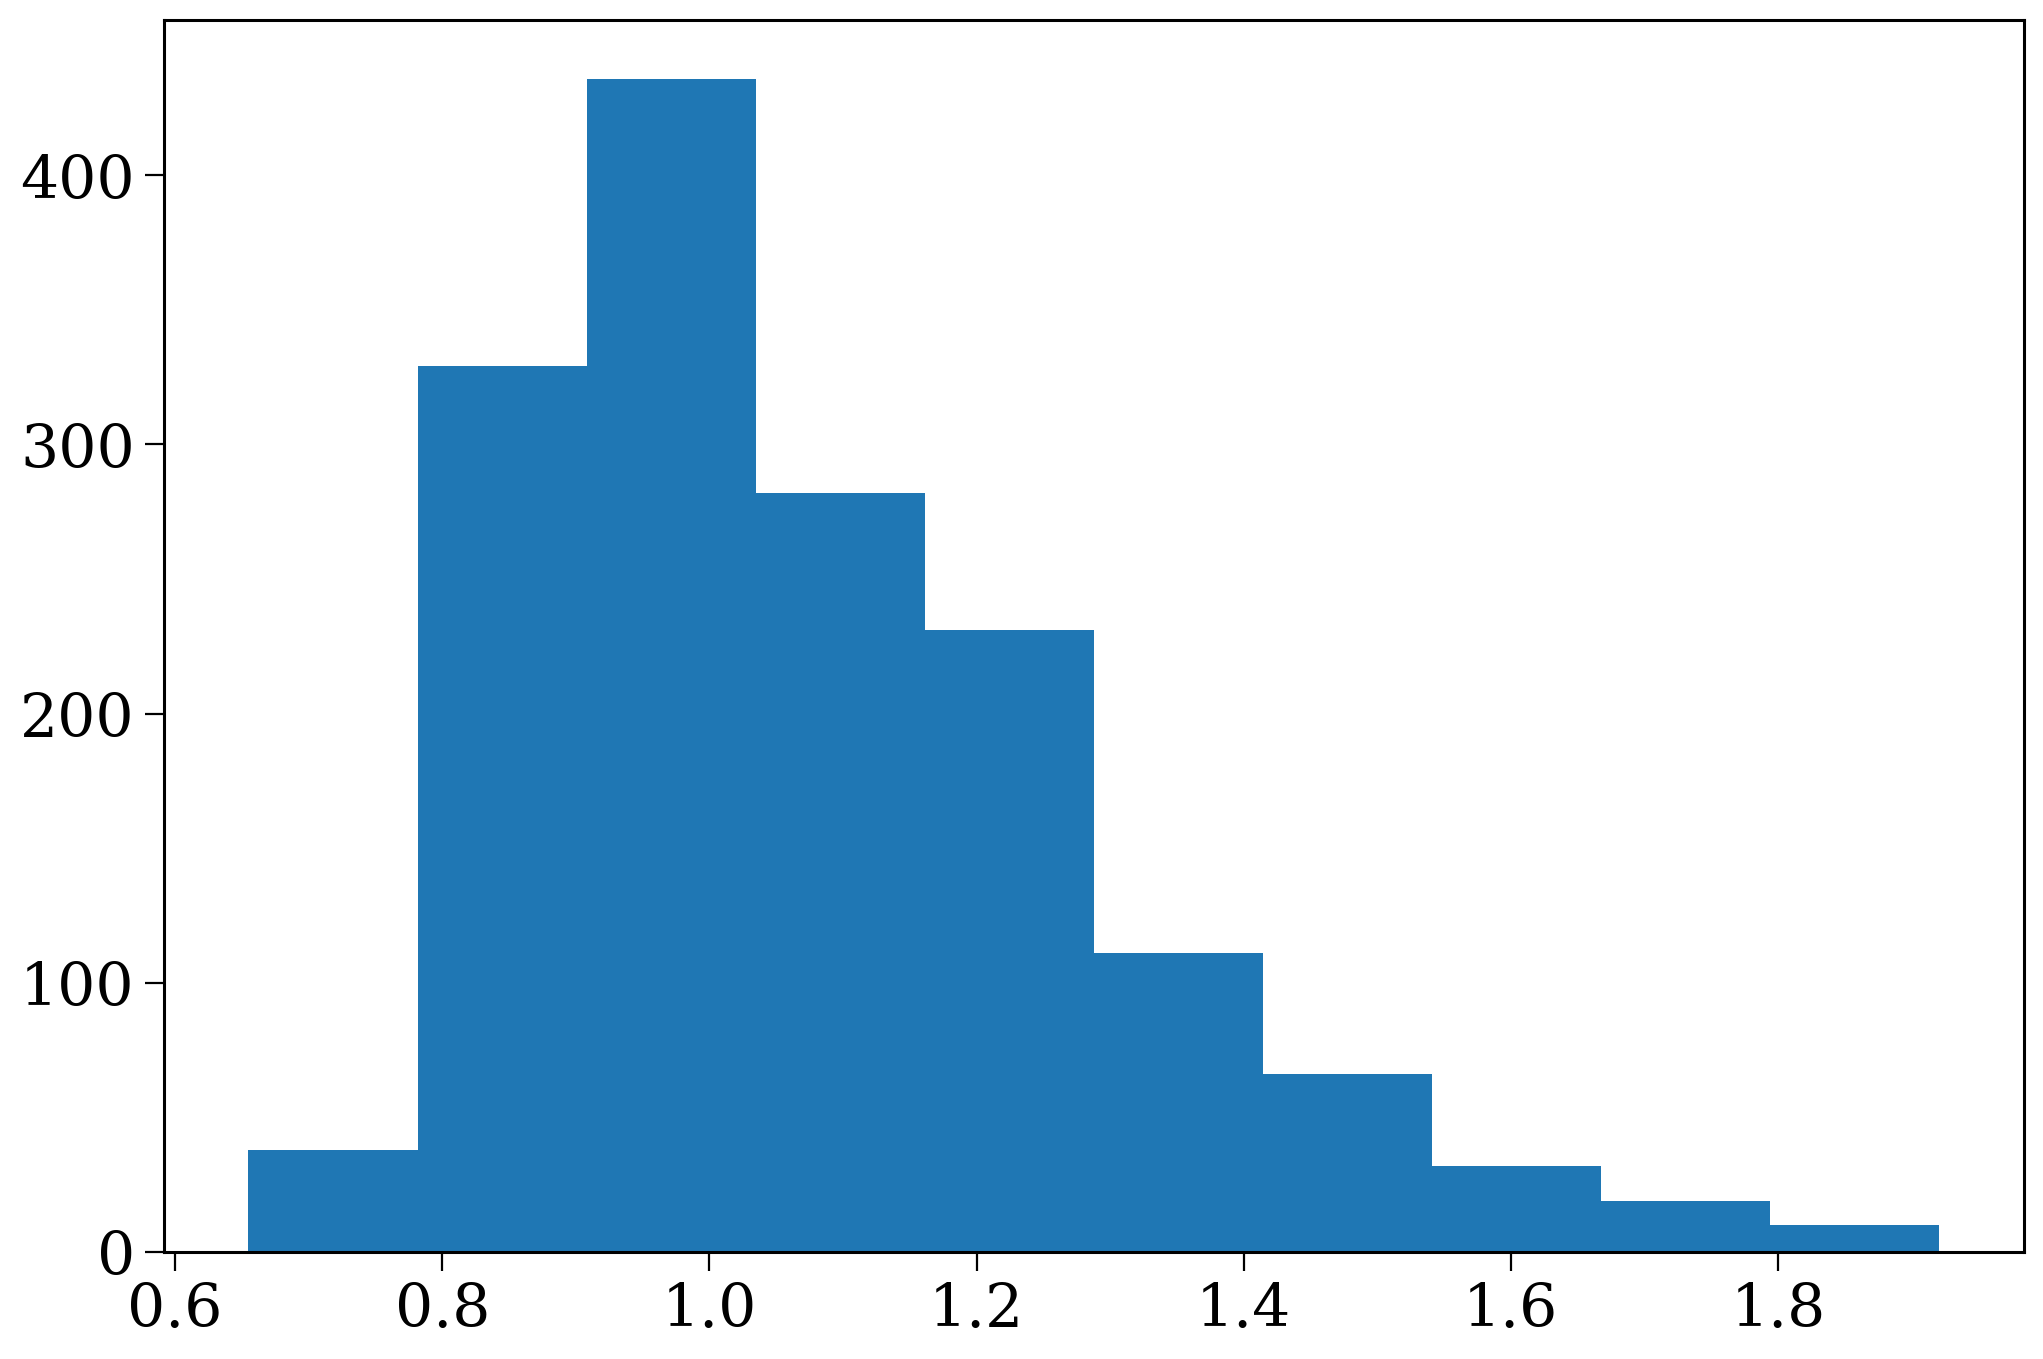

In [192]:
plt.hist(np.log10(p_runaways.initC["mass_2"]))

# Difference between theory and observation

In [ ]:
p_runaways.

In [20]:
p_runaways.bpp.loc[2]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
2,0.000000,22.248339,15.202071,1.0,1.0,1089.897515,681.431753,0.076246,0.015508,0.014591,1.0,0.000000,0.000000,7.671733e+00,1.231603e+01,0.000000,0.000000,6.437155,5.089674,22.248339,15.202071,5.692008e+04,1.996749e+04,35297.098016,30549.596510,0.000000,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.622704e+03,2.080168e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,2
2,7.788656,21.192251,15.137765,2.0,1.0,1123.513541,724.113813,0.076246,0.039822,0.021135,2.0,8.090102,7.815228,8.090101e+00,1.239045e+01,5.936502,0.000000,16.876800,7.681548,21.192251,15.137765,1.419443e+05,3.254156e+04,27393.913451,28096.668172,0.677646,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.229750e+02,8.831960e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,-0.301445,-0.026572,0.0,0.0,2
2,7.801917,21.164852,15.138981,4.0,1.0,1124.110435,724.952228,0.076237,0.928832,0.021140,2.0,8.103362,7.827594,8.090101e+00,1.238904e+01,6.055226,0.000000,393.743736,7.690038,21.192251,15.138981,1.504592e+05,3.258728e+04,5754.630755,28091.011158,0.686103,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.062610e-01,8.819602e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,-0.301445,-0.025677,0.0,0.0,2
2,7.809930,21.122579,15.143969,4.0,1.0,1038.740585,644.287489,0.000000,1.000972,0.021140,3.0,8.111375,7.831939,8.090101e+00,1.238323e+01,6.070669,0.000000,424.245189,7.696649,21.192251,15.143969,1.507541e+05,3.264152e+04,5546.620584,28090.623433,0.688622,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.561874e+00,3.561874e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,-0.301445,-0.022009,0.0,0.0,2
2,8.002723,6.487284,29.191437,4.0,1.0,2501.021346,2426.853834,0.000000,0.231778,0.007429,4.0,8.304168,2.098070,8.090101e+00,5.920392e+00,6.442260,0.000000,150.227389,9.506847,21.192251,29.191437,1.559519e+05,1.411024e+05,9400.321752,36444.748421,0.749290,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,9.768334e-13,3.642014e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,-0.301445,5.904653,0.0,0.0,2
2,8.014563,6.464920,29.191116,7.0,1.0,2502.089134,2429.180556,0.000000,0.001162,0.007433,2.0,0.218726,2.109930,9.057809e-01,5.920447e+00,0.000000,0.000000,0.753002,9.520571,6.464920,29.191116,6.093840e+04,1.413157e+05,104977.036193,36432.227593,0.000000,0.000000,6.464920e+00,1.000000e-10,7.530020e-01,1.000000e-10,7.614613e-05,3.627808e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,7.795837,5.904633,0.0,0.0,2
2,8.766294,5.271577,28.958998,8.0,1.0,2606.315408,2635.757930,0.000000,0.000984,0.007593,2.0,1.101875,2.878546,1.101874e+00,5.960518e+00,3.232894,0.000000,0.628922,10.465343,5.271577,28.958998,6.267499e+04,1.536238e+05,115676.433992,35481.951246,0.000070,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,6.800908e-03,2.819071e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,7.664420,5.887748,0.0,0.0,2
2,8.836026,5.083504,28.935764,8.0,1.0,2622.517285,2668.622968,0.000000,0.000984,0.007593,15.0,1.171252,2.949898,1.101874e+00,5.964557e+00,3.721335,0.000000,2.072868,10.566272,5.271577,28.935764,1.266574e+05,1.548631e+05,75969.878458,35383.084855,0.000070,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,4.259654e+06,2.748095e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,7.664420,5.885764,0.0,0.0,2
2,8.836026,1.844157,28.935764,13.0,1.0,-1.000000,-1.000000,-1.000000,0.000000,-2.000000,11.0,1.171252,2.949898,1.101874e+00,5.964557e+00,3.721335,0.000000,2.072868,10.566272,5.271577,28.935764,1.266574e+05,1.548631e+05,75969.878458,35383.084855,0.000070,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,4.259654e+06,2.748095e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,8.836026,5.885764,0.0,0.0,2
2,11.905253,1.844157,27.262552,13.0,2.0,-1.000000,-1.0000

In [15]:
p_runaways.bpp.loc[2]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
2,0.000000,22.248339,15.202071,1.0,1.0,1089.897515,681.431753,0.076246,0.015508,0.014591,1.0,0.000000,0.000000,7.671733e+00,1.231603e+01,0.000000,0.000000,6.437155,5.089674,22.248339,15.202071,5.692008e+04,1.996749e+04,35297.098016,30549.596510,0.000000,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.622704e+03,2.080168e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,2
2,7.788656,21.192251,15.137765,2.0,1.0,1123.513541,724.113813,0.076246,0.039822,0.021135,2.0,8.090102,7.815228,8.090101e+00,1.239045e+01,5.936502,0.000000,16.876800,7.681548,21.192251,15.137765,1.419443e+05,3.254156e+04,27393.913451,28096.668172,0.677646,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.229750e+02,8.831960e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,-0.301445,-0.026572,0.0,0.0,2
2,7.801917,21.164852,15.138981,4.0,1.0,1124.110435,724.952228,0.076237,0.928832,0.021140,2.0,8.103362,7.827594,8.090101e+00,1.238904e+01,6.055226,0.000000,393.743736,7.690038,21.192251,15.138981,1.504592e+05,3.258728e+04,5754.630755,28091.011158,0.686103,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.062610e-01,8.819602e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,-0.301445,-0.025677,0.0,0.0,2
2,7.809930,21.122579,15.143969,4.0,1.0,1038.740585,644.287489,0.000000,1.000972,0.021140,3.0,8.111375,7.831939,8.090101e+00,1.238323e+01,6.070669,0.000000,424.245189,7.696649,21.192251,15.143969,1.507541e+05,3.264152e+04,5546.620584,28090.623433,0.688622,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.561874e+00,3.561874e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,-0.301445,-0.022009,0.0,0.0,2
2,8.002723,6.487284,29.191437,4.0,1.0,2501.021346,2426.853834,0.000000,0.231778,0.007429,4.0,8.304168,2.098070,8.090101e+00,5.920392e+00,6.442260,0.000000,150.227389,9.506847,21.192251,29.191437,1.559519e+05,1.411024e+05,9400.321752,36444.748421,0.749290,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,9.768334e-13,3.642014e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,-0.301445,5.904653,0.0,0.0,2
2,8.014563,6.464920,29.191116,7.0,1.0,2502.089134,2429.180556,0.000000,0.001162,0.007433,2.0,0.218726,2.109930,9.057809e-01,5.920447e+00,0.000000,0.000000,0.753002,9.520571,6.464920,29.191116,6.093840e+04,1.413157e+05,104977.036193,36432.227593,0.000000,0.000000,6.464920e+00,1.000000e-10,7.530020e-01,1.000000e-10,7.614613e-05,3.627808e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,7.795837,5.904633,0.0,0.0,2
2,8.766294,5.271577,28.958998,8.0,1.0,2606.315408,2635.757930,0.000000,0.000984,0.007593,2.0,1.101875,2.878546,1.101874e+00,5.960518e+00,3.232894,0.000000,0.628922,10.465343,5.271577,28.958998,6.267499e+04,1.536238e+05,115676.433992,35481.951246,0.000070,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,6.800908e-03,2.819071e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,7.664420,5.887748,0.0,0.0,2
2,8.836026,5.083504,28.935764,8.0,1.0,2622.517285,2668.622968,0.000000,0.000984,0.007593,15.0,1.171252,2.949898,1.101874e+00,5.964557e+00,3.721335,0.000000,2.072868,10.566272,5.271577,28.935764,1.266574e+05,1.548631e+05,75969.878458,35383.084855,0.000070,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,4.259654e+06,2.748095e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,7.664420,5.885764,0.0,0.0,2
2,8.836026,1.844157,28.935764,13.0,1.0,-1.000000,-1.000000,-1.000000,0.000000,-2.000000,11.0,1.171252,2.949898,1.101874e+00,5.964557e+00,3.721335,0.000000,2.072868,10.566272,5.271577,28.935764,1.266574e+05,1.548631e+05,75969.878458,35383.084855,0.000070,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,4.259654e+06,2.748095e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,8.836026,5.885764,0.0,0.0,2
2,11.905253,1.844157,27.262552,13.0,2.0,-1.000000,-1.0000

In [48]:
sn_rows = p.bpp.loc[kicked_bin_nums][(p.bpp.loc[kicked_bin_nums]["evol_type"] == 15) | (p.bpp.loc[kicked_bin_nums]["evol_type"] == 16)]

# COSMIC bug searching

In [128]:
hehg_at_mt_onset = p.bpp[(p.bpp["kstar_1"] == 8) & (p.bpp["evol_type"] == 3)]["bin_num"]
hehg_at_mt_end = p.bpp[(p.bpp["kstar_1"] == 8) & (p.bpp["evol_type"] == 4)]["bin_num"]
ce = p.bpp[p.bpp["evol_type"] == 7]["bin_num"]

In [146]:
started_mt_as_hehg = np.isin(p.bin_nums, hehg_at_mt_onset)
finished_mt_as_hehg = np.isin(p.bin_nums, hehg_at_mt_end)
experienced_ce = np.isin(p.bin_nums, ce)

In [147]:
started_mt_as_hehg.sum()

48760

In [151]:
(finished_mt_as_hehg & ~started_mt_as_hehg & experienced_ce).sum()

5072